In [1]:
import matplotlib
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as crs
import matplotlib.gridspec as gridspec 
from matplotlib.colorbar import Colorbar 
import cartopy

In [2]:
matplotlib.rcParams.update({'font.size': 20})

In [3]:
sla = xr.open_dataset("./Satellite_Data_SAC/sla_BOB_2018.nc")

We find below that the data is absolute dynamic ocean topography and not the sea level anomaly

$\Large SLA = ADT - \overline{ADT}$

Where, SLA is the sea level anomaly, ADT is the absolute dynamic topography, and $\overline{ADT}$ is the time mean

In [4]:
sla

<xarray.Dataset>
Dimensions:    (latitude: 80, longitude: 88, time: 365)
Coordinates:
  * time       (time) datetime64[ns] 2018-01-01 2018-01-02 ... 2018-12-31
  * longitude  (longitude) float32 78.125 78.375 78.625 ... 99.375 99.625 99.875
  * latitude   (latitude) float32 5.125 5.375 5.625 ... 24.375 24.625 24.875
Data variables:
    adt        (time, latitude, longitude) float64 ...
Attributes:
    CDI:                             Climate Data Interface version 1.9.4 (ht...
    Conventions:                     CF-1.6
    history:                         Fri Feb 15 15:49:27 2019: cdo sellonlatb...
    source:                          Altimetry measurements
    institution:                     CLS, CNES
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Grid
    comment:                         Sea Surface Height measured by Altimetry...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:    

We compute the sea level anomaly as below:

In [5]:
sla_anom = sla.adt - sla.adt.mean(dim='time')

/home/aditya/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


We shall change the name of the data variable sla_anom as "SLA (m)", otherwise, it simply copies the name from the ADT variable

In [6]:
sla_anom.name = "SLA(m)"

We need a high resolution land mask which will resolve the Andaman islands as well, so let's make use of Cartopy's feature and download a 50m resolution land mask. We'll give it a facecolor of black

In [8]:
import cartopy.feature as cfeature
land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor= 'k')

Let's plot an example plot at the first time step before looping over each time step and plotting frames to produce an animated figure

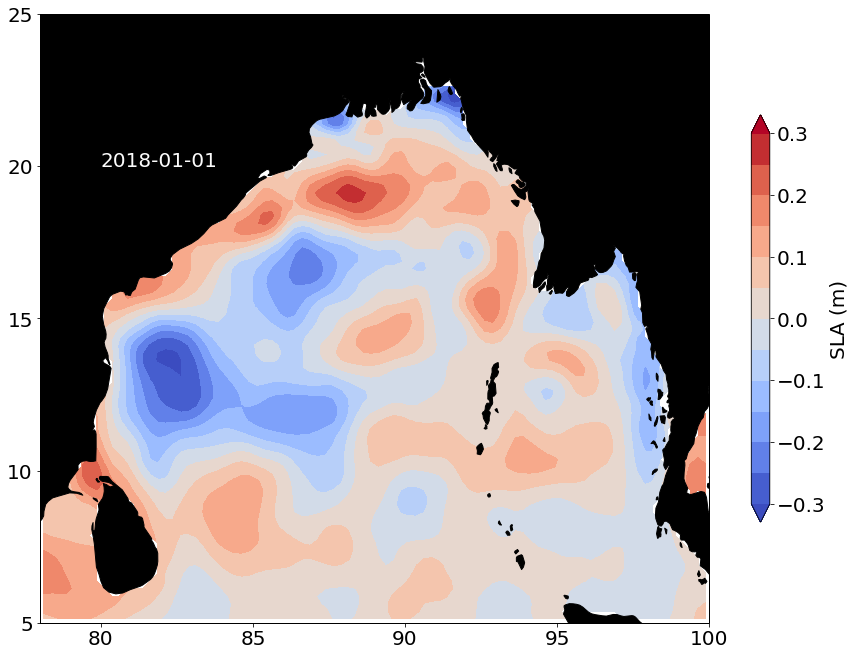

In [10]:
plt.close(1)
plt.figure(1, figsize=(15, 15))
ax = plt.subplot(projection=crs.PlateCarree())
#ax.coastlines()
t = sla_anom.time[0]
Q = plt.contourf(sla_anom.longitude, sla_anom.latitude, sla_anom.isel(time=0), vmin=-0.3, vmax=0.3, 
                 levels=np.arange(-0.3, 0.31, 0.05), extend='both', cmap='coolwarm')
ax.set_extent([78, 100, 5, 25])
ax.set_xticks(np.arange(80, 101, 5) )
ax.set_yticks(np.arange(5, 26, 5) )

ax.add_feature(land_50m)
plt.text(80,20, str.split(str(t.values), 'T')[0], color='0.99')
#longrid, latgrid = np.meshgrid(bathyS.lon.values, bathyS.lat.values)
#ax.contourf(longrid, latgrid, bathyS.elevation.where(bathyS.elevation > 0).values, cmap='Greens' )

plt.colorbar(Q, ax=ax, shrink=0.5, label="SLA (m)")
plt.show()

Next, we need to find the indices at the time step which fall within our period of 1st April to 31st October

In [12]:
np.where(sla_anom.time == np.datetime64("2018-04-01") )

(array([90]),)

In [11]:
np.where(sla_anom.time == np.datetime64("2018-10-31") )

(array([303]),)

In [16]:
!rm ./animations/sla/*.png

Let's loop over between the above indices at a daily interval

/home/aditya/anaconda3/lib/python3.7/site-packages/matplotlib/tight_layout.py:176: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. The left and right margins '


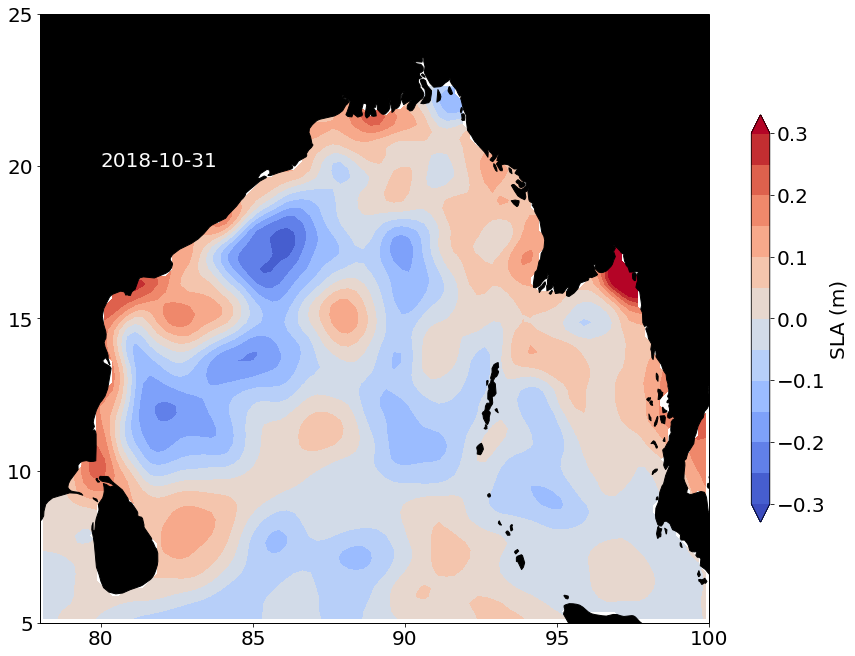

In [18]:
for tind in range(90, 304, 1):
    t = sla_anom.time[tind]
    plt.close(1)
    plt.figure(1, figsize=(15, 15))
    ax = plt.subplot(projection=crs.PlateCarree())
    #ax.coastlines()

    CF = plt.contourf(sla_anom.longitude, sla_anom.latitude, sla_anom.sel(time=t), vmin=-0.3, vmax=0.3, 
                 levels=np.arange(-0.3, 0.31, 0.05), extend='both', cmap='coolwarm')
    ax.set_extent([78, 100, 5, 25])
    ax.set_xticks(np.arange(80, 101, 5) )
    ax.set_yticks(np.arange(5, 26, 5) )

    ax.add_feature(land_50m)
    plt.text(80,20, str.split(str(t.values), 'T')[0], color='0.99')

    plt.colorbar(CF, ax=ax, shrink=0.5, label="SLA (m)")
    plt.tight_layout()
    #plt.title(str.split(str(t.values), 'T')[0])
    plt.savefig("./animations/sla/"+str.split(str(t.values), 'T')[0]+".png" )

Next, we use any tool to stitch together the frames produced to make an animation. If you have a Linux system, you can install imagemagik and run the following script